# 3DRDNN

Main pipeline for research in my Master.

## goals in this notebook

Prepare the pipeline for any 3d DNN to train on CT data.
1) data loader
2) DNN
3) Training
4) Results comparison

In [1]:
# Testing reading GPU
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np
import glob
# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print(tf.test.gpu_device_name())

TensorFlow Version: 2.8.0
/device:GPU:0


In [2]:
# Data loader
from utils import data_loader
import random



loader = data_loader.NiiDataLoader()
"""
#random.shuffle(files_segmenation)
#random.shuffle(files_volume)

train_volume = files_volume[0:22]
train_segmentation = files_segmenation[0:22]

print(train_volume)
print(train_segmentation)

valid_volume = files_volume[22:]
valid_segmentation = files_segmenation[22:]

print(valid_volume)
print(valid_segmentation)


"""

train_generator = loader.data_generator_2d(0)
valid_generator = loader.data_generator_2d(1)
counter_train = 11391
counter_valid = 3527

print(type(train_generator))
"""
for x in train_generator:
    counter_train+=1

for x in valid_generator:
    counter_valid+=1"""

"""<class 'generator'> 
counter_train 3372
counter_valid 1138"""
counter_train = 0
counter_valid = 0
for x in train_generator:
    counter_train+=1
for x in valid_generator:
    counter_valid+=1
print(counter_train)
print(counter_valid)

<class 'generator'>
3372
1138


In [3]:
#datasets for tf
batch_size = 8
dataset = tf.data.Dataset.from_generator(
     loader.data_generator_2d,
     (tf.float32,tf.float32), 
    (tf.TensorShape([256,256,1]), tf.TensorShape([256,256,2])), args = ([0]))
dataset = dataset.repeat(101).batch(batch_size)

valid_dataset = tf.data.Dataset.from_generator(
     loader.data_generator_2d,
     (tf.float32,tf.float32), 
    (tf.TensorShape([256,256,1]), tf.TensorShape([256,256,2])),args = ([1]))
valid_dataset = valid_dataset.repeat(100).batch(batch_size) #.shuffle(1000,  reshuffle_each_iteration=True)


print(dataset)
print(valid_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>


In [7]:
# Network set-up
from utils import models

model = models.model_call(model_name="2DUNET",px=256,features=16)

In [8]:
# Metrics and training

import tensorflow.keras.backend as K
def dice(y_true, y_pred):
    smooth = 1
    intersection = K.sum(y_true * y_pred, axis=list(range(1, K.ndim(y_true))))
    union = K.sum(y_true, axis=list(range(1, K.ndim(y_true)))) + K.sum(y_pred, axis=list(range(1, K.ndim(y_true))))
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

 
adam = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
precision_all = tf.keras.metrics.Precision(
    thresholds=0.5)
precision = tf.keras.metrics.Precision(
    thresholds=0.5, class_id=1)
recall = tf.keras.metrics.Recall(
    thresholds=0.5, class_id=1)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=[precision_all,precision,recall])
model.summary(positions=[.33, .66, .78, 1.])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape                    Param #     Connected to          
 input_2 (InputLayer)           [(None, 256, 256, 1)]           0           []                    
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16)            160         ['input_2[0][0]']     
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 16)            2320        ['conv2d_19[0][0]']   
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 16)           0           ['conv2d_20[0][0]']   
                                                                                            

In [9]:
# Results
# reading checkpoint if needen
#
#################################

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TerminateOnNaN
# training
callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0000001, verbose=1),
    ModelCheckpoint("2DUNET_liver_test.h5", verbose=1, save_best_only=True, save_weights_only=True),
    TerminateOnNaN()]
epochs = 10
steps_per_epoch = counter_train / batch_size #ilość kawałków x plików / batch_size* z dokładnościa do dziielnia przez 32

validations_steps = counter_valid / batch_size #ilość kawałków x plików /batch_size
history = model.fit(dataset,validation_data=valid_dataset, callbacks=callbacks, initial_epoch=0,
                    epochs=epochs, validation_steps = validations_steps, steps_per_epoch=steps_per_epoch
                    )

Epoch 1/10
422/421 [==============================] - ETA: 0s - loss: 0.1439 - precision_1: 0.9358 - precision_2: 0.5567 - recall_1: 0.2158
Epoch 1: val_loss improved from inf to 0.12470, saving model to 2DUNET_liver_test.h5
421/421 [==============================] - 137s 319ms/step - loss: 0.1439 - precision_1: 0.9358 - precision_2: 0.5567 - recall_1: 0.2158 - val_loss: 0.1247 - val_precision_1: 0.9292 - val_precision_2: 0.1448 - val_recall_1: 0.0473 - lr: 0.0100
Epoch 2/10
422/421 [==============================] - ETA: 0s - loss: 0.1205 - precision_1: 0.9376 - precision_2: 0.5511 - recall_1: 0.3875
Epoch 2: val_loss improved from 0.12470 to 0.10819, saving model to 2DUNET_liver_test.h5
421/421 [==============================] - 135s 321ms/step - loss: 0.1205 - precision_1: 0.9376 - precision_2: 0.5511 - recall_1: 0.3875 - val_loss: 0.1082 - val_precision_1: 0.9426 - val_precision_2: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 0.0100
Epoch 3/10
422/421 [==============================

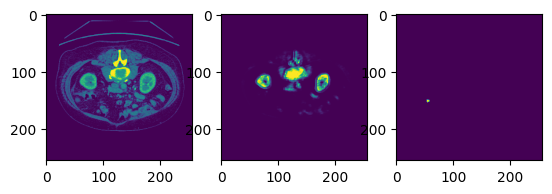

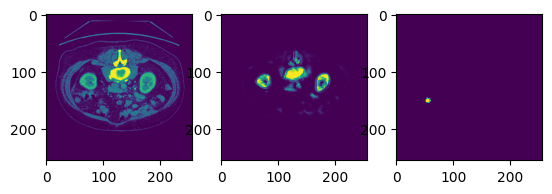

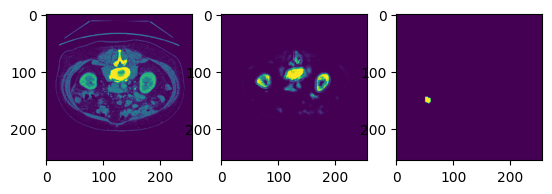

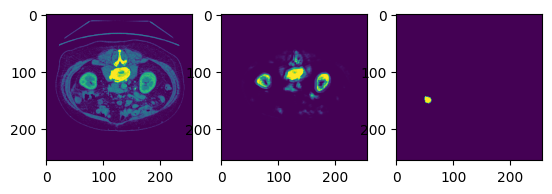

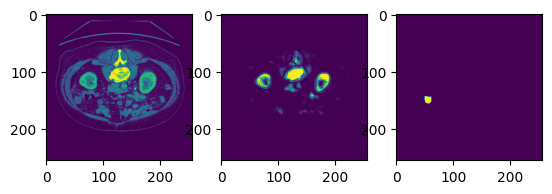

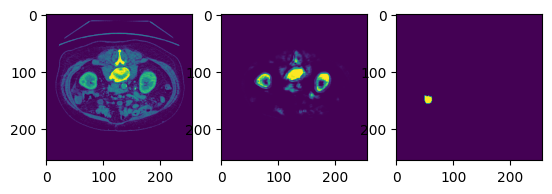

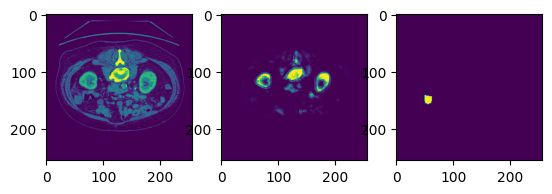

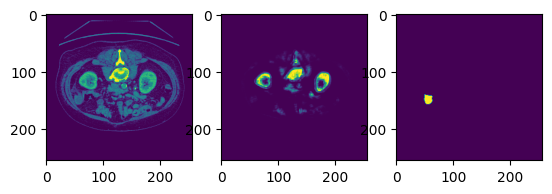

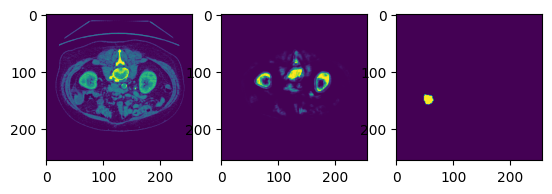

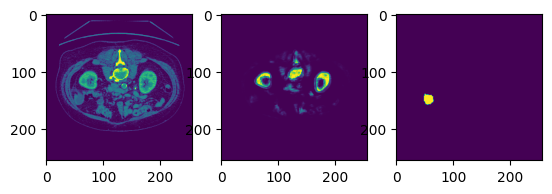

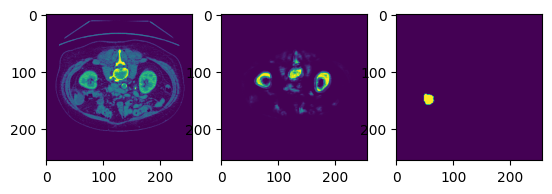

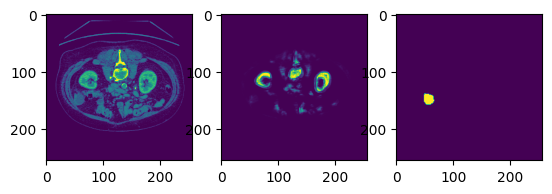

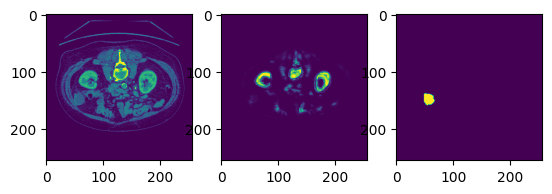

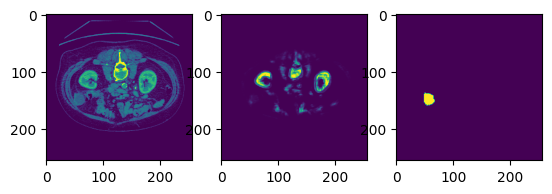

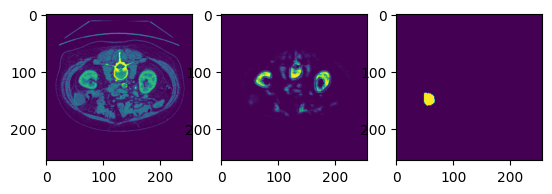

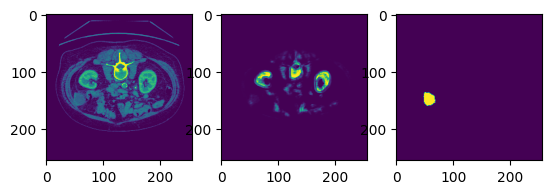

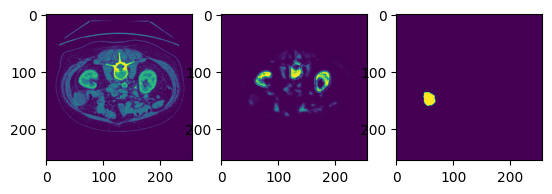

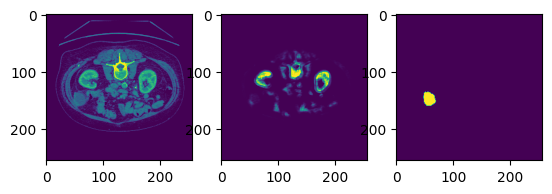

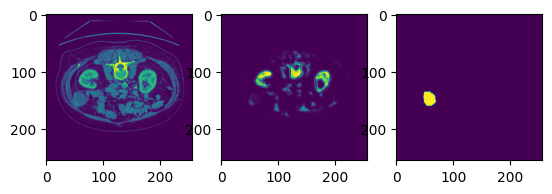

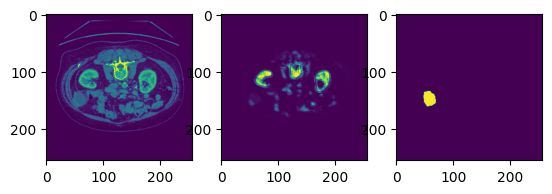

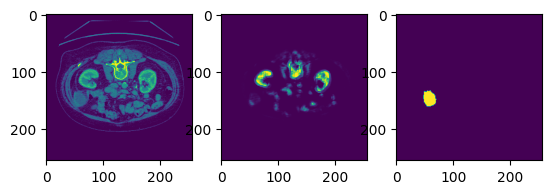

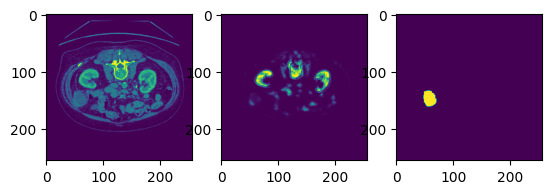

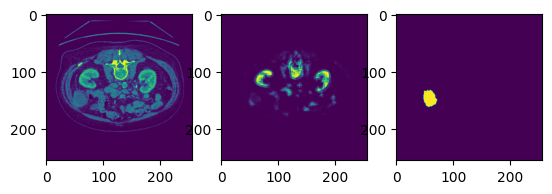

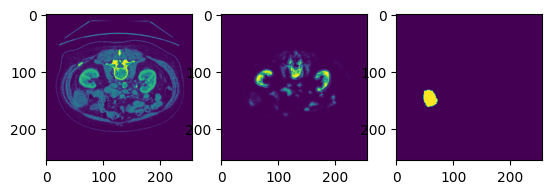

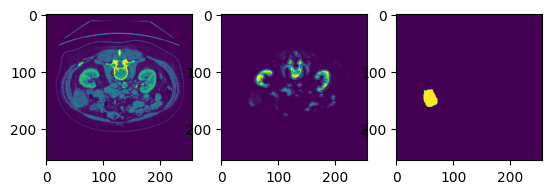

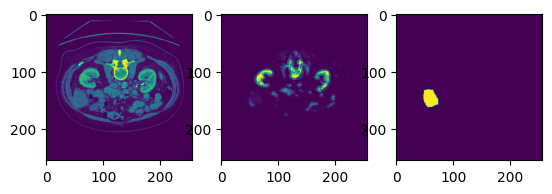

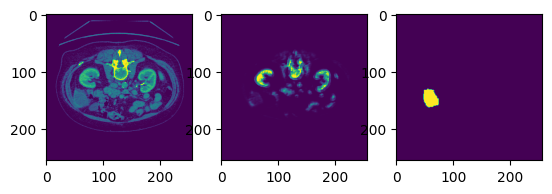

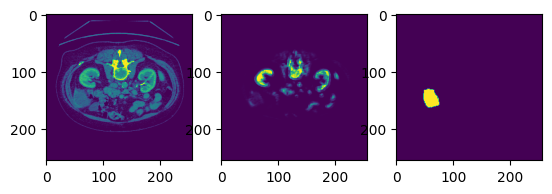

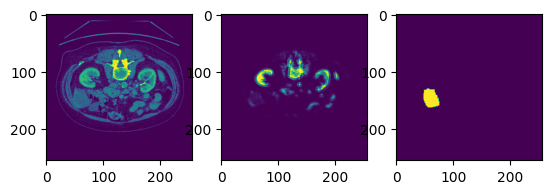

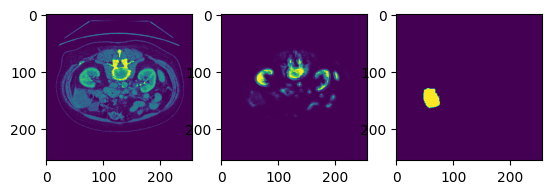

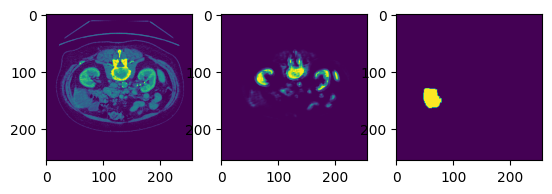

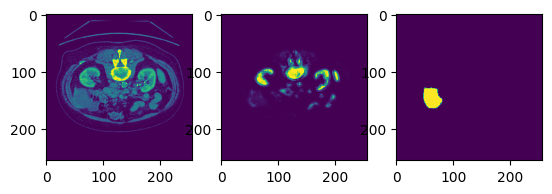

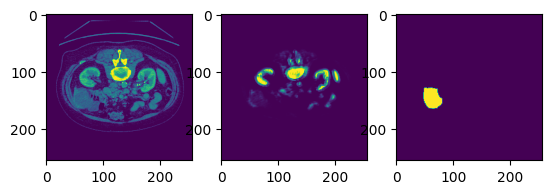

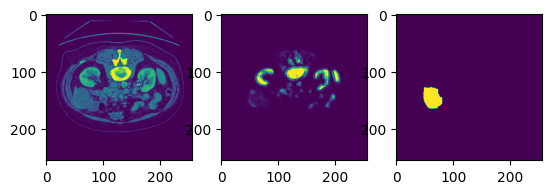

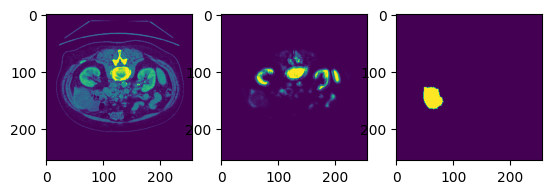

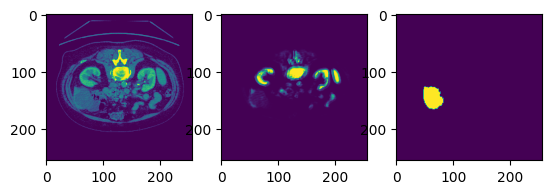

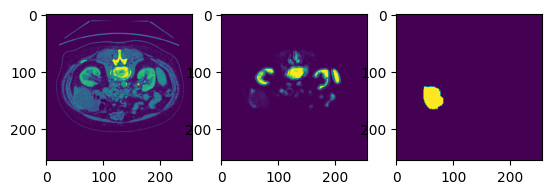

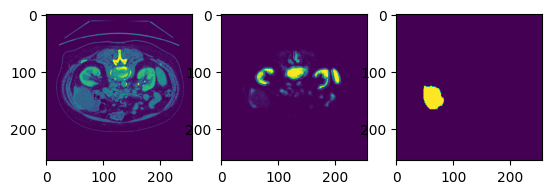

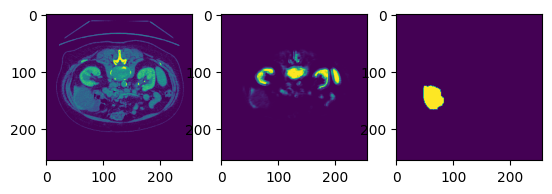

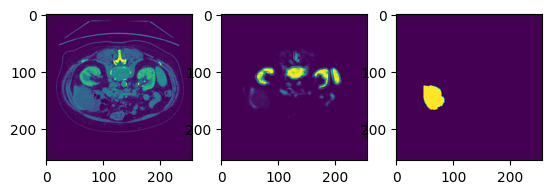

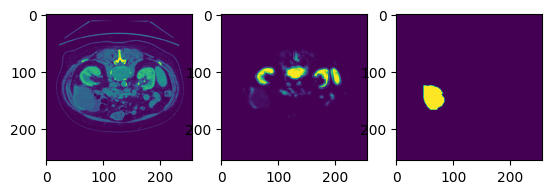

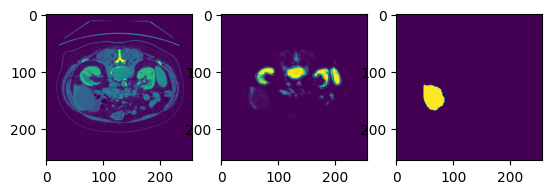

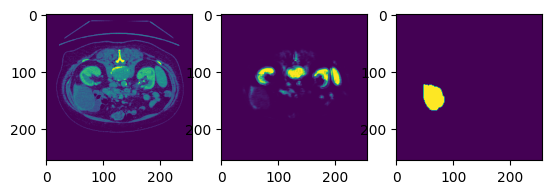

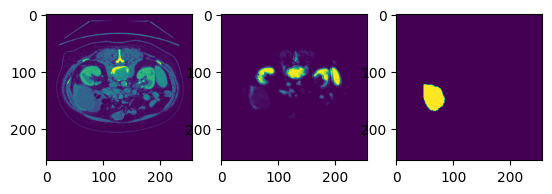

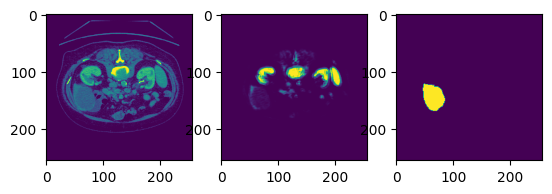

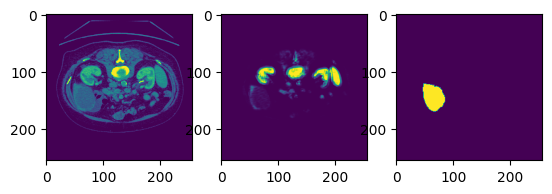

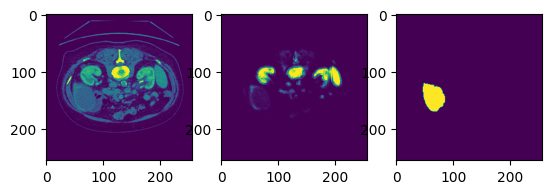

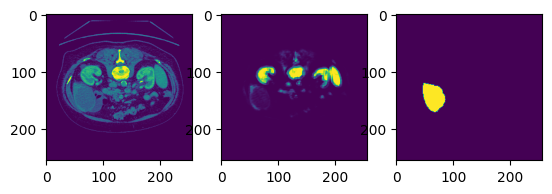

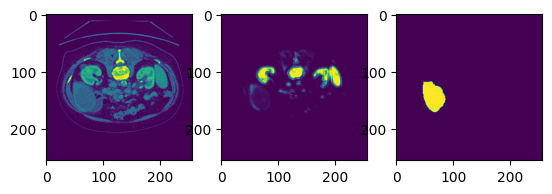

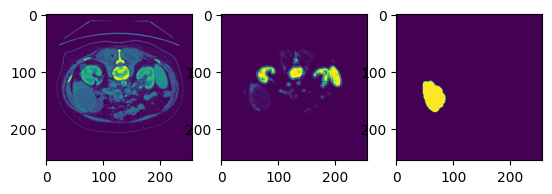

KeyboardInterrupt: 

In [23]:
n_max = 100
n=0
for x in loader.data_generator_2d(1):
   if n < n_max:
    plt.subplot(1,3,1)
    plt.imshow(x[0])
    plt.subplot(1,3,2)
    preds = model.predict(tf.reshape(x[0],[1,256,256,1]))
    plt.imshow(preds[0,:,:,1])
    plt.subplot(1,3,3)
    plt.imshow(x[1][:,:,1])
    plt.show()

   n+=1